# Clustering with Neural Networks on AG News Dataset


## 1. Setup and Imports
Install and import required libraries.

In [1]:
!pip install torch torchvision datasets transformers scikit-learn matplotlib seaborn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import logging
import os
%matplotlib inline

# Set up logging
logging.basicConfig(level=logging.INFO)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Load and Preprocess AG News Dataset
Load 10% of the `sh0416/ag_news` dataset and use Sentence-BERT for text embeddings.

In [2]:
# Load AG News dataset
ds = load_dataset("sh0416/ag_news", trust_remote_code=True)

train_data = ds['train']
# Use 10% of the training data
num_samples = int(0.1 * len(train_data))
texts = [f"{sample['title']} {sample['description']}" for sample in train_data][:num_samples]
labels = train_data['label'][:num_samples]
print(f"Successfully processed dataset. Number of samples: {len(texts)}")
print(f"Sample text: {texts[0]}")

try:
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    sbert_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    print("Successfully loaded Sentence-BERT model and tokenizer.")
except Exception as e:
    print(f"Error loading Sentence-BERT model: {e}")
    raise SystemExit("Model loading failed. Stopping execution.")

def get_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = sbert_model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings.cpu())
    return torch.cat(embeddings).numpy()

try:
    initial_embeddings = get_embeddings(texts)
    print(f"Shape of initial embeddings: {initial_embeddings.shape}")
except Exception as e:
    print(f"Error generating embeddings: {e}")
    raise SystemExit("Embedding generation failed. Stopping execution.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Successfully processed dataset. Number of samples: 12000
Sample text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Successfully loaded Sentence-BERT model and tokenizer.
Shape of initial embeddings: (12000, 384)


## 3. Define STM_clusterizer Model
Define an STM_clusterizer to refine the embeddings into a lower-dimensional latent space.

In [3]:
class STM_clusterizer(nn.Module):
    def __init__(self, input_size=384, hidden_size=128):
        super(STM_clusterizer, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, input_size)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = STM_clusterizer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 4. Create DataLoader for Training
Convert embeddings into a PyTorch Dataset.

In [4]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx]

dataset = EmbeddingDataset(initial_embeddings)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

## 5. Train STM_clusterizer
Train the STM_clusterizer to learn a compact latent space.

In [5]:
epochs = 20
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        encoded, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}')

Epoch [1/20], Loss: 0.0189
Epoch [2/20], Loss: 0.0115
Epoch [3/20], Loss: 0.0096
Epoch [4/20], Loss: 0.0087
Epoch [5/20], Loss: 0.0082
Epoch [6/20], Loss: 0.0079
Epoch [7/20], Loss: 0.0078
Epoch [8/20], Loss: 0.0077
Epoch [9/20], Loss: 0.0076
Epoch [10/20], Loss: 0.0076
Epoch [11/20], Loss: 0.0075
Epoch [12/20], Loss: 0.0075
Epoch [13/20], Loss: 0.0075
Epoch [14/20], Loss: 0.0075
Epoch [15/20], Loss: 0.0075
Epoch [16/20], Loss: 0.0074
Epoch [17/20], Loss: 0.0074
Epoch [18/20], Loss: 0.0074
Epoch [19/20], Loss: 0.0074
Epoch [20/20], Loss: 0.0074


## 6. Extract Latent Embeddings
Use the trained encoder to get latent embeddings.

In [6]:
model.eval()
latent_embeddings = []
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        encoded, _ = model(batch)
        latent_embeddings.append(encoded.cpu().numpy())
latent_embeddings = np.concatenate(latent_embeddings)
print(f'Shape of latent embeddings: {latent_embeddings.shape}')

Shape of latent embeddings: (12000, 128)


## 7. Apply K-Means Clustering
Cluster the latent embeddings using K-Means.

In [7]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_embeddings)
print(f'Cluster labels shape: {cluster_labels.shape}')

Cluster labels shape: (12000,)


## 8. Evaluate Clustering
Compute Silhouette Score and Davies-Bouldin Index.

In [8]:
sil_score = silhouette_score(latent_embeddings, cluster_labels)
db_score = davies_bouldin_score(latent_embeddings, cluster_labels)
print(f'Silhouette Score: {sil_score:.4f}')
print(f'Davies-Bouldin Index: {db_score:.4f}')

Silhouette Score: 0.0540
Davies-Bouldin Index: 3.5457


## 9. Visualize Clusters with t-SNE
Visualize the clusters in 2D using t-SNE.

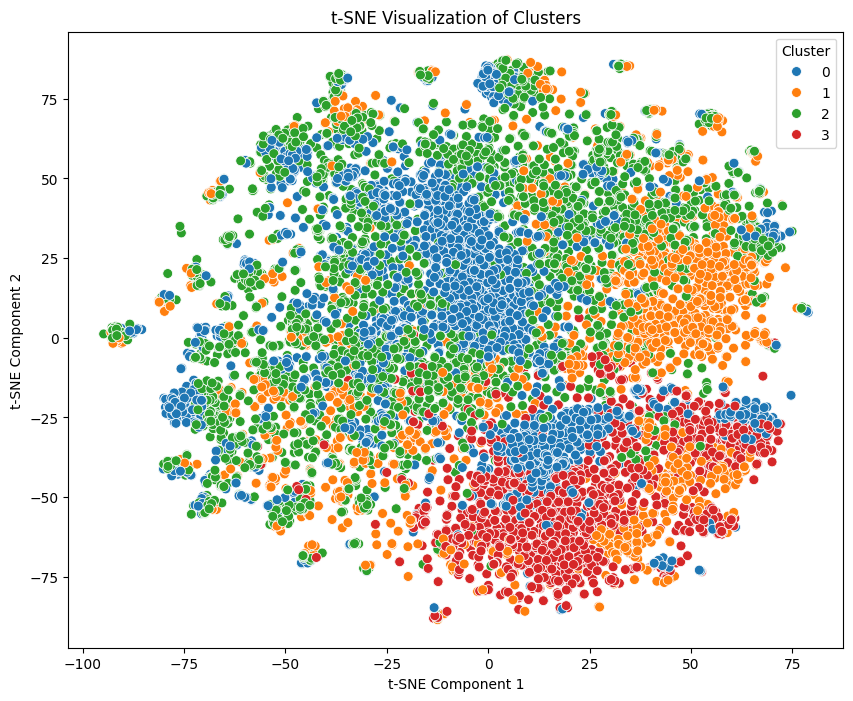

In [9]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(latent_embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=cluster_labels, palette='tab10', s=50)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.savefig('tsne_clusters.png')
plt.show()

## 10. Conclusion
This notebook implemented an STM_clusterizer-based clustering pipeline using 10% of the `sh0416/ag_news` dataset (12,000 samples). The Sentence-BERT model generated initial text embeddings, which were refined by an STM_clusterizer into a 128-dimensional latent space. K-Means clustering was applied with 4 clusters, and results were evaluated using Silhouette Score and Davies-Bouldin Index. The t-SNE visualization provides insight into cluster separation.

**References**:
- Hugging Face Datasets: https://huggingface.co/docs/datasets/index
- PyTorch: https://pytorch.org
- Sentence-Transformers: https://www.sbert.net/